# Multilevel Monte Carlo Path Simulation

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import sys

# Add the path to the mlmc module to the python path
sys.path.append("../src")
from mlmc import MLMC
from model import BlackScholes
from contract import *

In [7]:
# Model parameters
interest_rate = 0.05
initial_value = 1.0
sigma = 0.2

model = BlackScholes(interest_rate, initial_value, sigma)

# Contract parameters
maturity = 1.0
strike = 1.0

# contract = EuropeanCall(maturity, strike)
contract = EuropeanPut(maturity, strike)
# contract = AsianCall(maturity, strike)
# contract = AsianPut(maturity, strike)

In [8]:
# MLMC parameters
max_level = 4
default_sample_count = 10_000
m = 4
# For reproducibility
rng = np.random.default_rng(seed=42)
# rng = np.random.default_rng()

mlmc = MLMC(max_level, m, default_sample_count, rng)

# As in the paper
target_errors = np.array([0.00005, 0.0001, 0.0002, 0.0005, 0.001])
costs = np.zeros_like(target_errors)
mlmc_stats = []

for i, target_error in enumerate(target_errors):
    mlmc_stats.append(mlmc.estimate(target_error, model, contract))

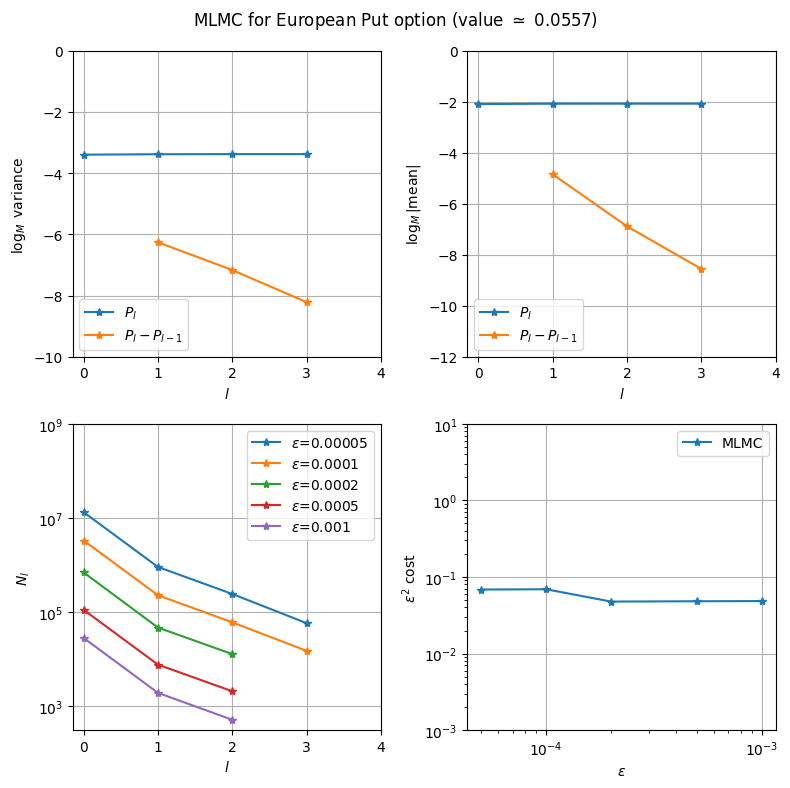

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8), dpi=100)

for i, (target_error, stat) in enumerate(zip(target_errors, mlmc_stats)):
    estimator, samples_per_level, final_level = stat
    costs[i] = estimator["cost"]
    levels = np.arange(final_level + 1)

    if i == 0:  # Creating the plot for the first estimator
        value = np.sum(estimator["means"])
        fig.suptitle(f"MLMC for {contract.name()} option (value $\\simeq$ {value:.4f})")

        log_vars = np.log(np.cumsum(estimator["vars"][: len(levels)])) / np.log(m)
        axs[0, 0].plot(levels, log_vars, label=rf"$P_l$", marker="*")
        log_vars = np.log(estimator["vars"][1 : len(levels)]) / np.log(m)
        axs[0, 0].plot(levels[1:], log_vars, label=f"$P_l-P_{{l-1}}$", marker="*")

        log_means = np.log(np.abs(np.cumsum(estimator["means"][: len(levels)]))) / np.log(m)
        axs[0, 1].plot(levels, log_means, label=rf"$P_l$", marker="*")
        log_means = np.log(np.abs(estimator["means"][1 : len(levels)])) / np.log(m)
        axs[0, 1].plot(levels[1:], log_means, label=rf"$P_l-P_{{l-1}}$", marker="*")

    eps_str = f"{target_error:.5f}".rstrip("0")
    axs[1, 0].plot(levels, samples_per_level[: len(levels)], label=rf"$\varepsilon$={eps_str}", marker="*")

axs[1, 1].plot(target_errors, costs * target_errors**2, label="MLMC", marker="*")

# Top left
axs[0, 0].set_xlabel("$l$")
axs[0, 0].set_ylabel("$\\log_M$ variance")
axs[0, 0].set_xticks(ticks=np.arange(max_level + 1))
axs[0, 0].set_yticks(ticks=np.arange(-10, 1, 2))
axs[0, 0].minorticks_off()
axs[0, 0].grid(which="major")
axs[0, 0].legend(loc="lower left")

# Top right
axs[0, 1].set_xlabel("$l$")
axs[0, 1].set_ylabel("$\\log_M$|mean|")
axs[0, 1].set_xticks(ticks=np.arange(max_level + 1))
axs[0, 1].set_yticks(ticks=np.arange(-12, 1, 2))
axs[0, 1].minorticks_off()
axs[0, 1].grid(which="major")
axs[0, 1].legend(loc="lower left")

# Bottom left
axs[1, 0].set_xlabel("$l$")
axs[1, 0].set_ylabel("$N_l$")
axs[1, 0].set_yscale("log")
axs[1, 0].set_xticks(ticks=np.arange(max_level + 1))
axs[1, 0].set_yticks(ticks=10.0 ** np.arange(3, 11, 2))
axs[1, 0].minorticks_off()
axs[1, 0].grid(which="major")
axs[1, 0].legend(loc="best")

# Bottom right
axs[1, 1].set_xlabel("$\\epsilon$")
axs[1, 1].set_ylabel("$\\epsilon^2$ cost")
axs[1, 1].set_xscale("log")
axs[1, 1].set_yscale("log")
axs[1, 1].set_yticks(ticks=10.0 ** np.arange(-3, 2))
axs[1, 1].grid(which="major")
axs[1, 1].legend(loc="best")
fig.tight_layout()

plt.show()

In [10]:
# Confidence interval
estimator, samples_per_level, final_level = mlmc_stats[0]
p = np.sum(estimator["means"])
s = np.sum(np.sqrt(estimator["vars"]))
n = np.sum(samples_per_level[:final_level])

print(f"=============== MLMC ===============")
print(f"Estimator: {p}")
print(f"Confidence interval 95%: [{p - 1.96 * s / np.sqrt(n)},{p + 1.96 * s / np.sqrt(n)}]")
print(f"Error: {100 * 1.96 * s / (p * np.sqrt(n))}%")

n = samples_per_level[final_level]

t = np.linspace(0, contract.maturity, m**final_level + 1)
dt = contract.maturity / m**final_level
dw = rng.normal(scale=np.sqrt(dt), size=(n, m**final_level))

s = np.zeros((dw.shape[0], dw.shape[1] + 1))
s[:, 0] = model.initial_value
for i in range(dw.shape[1]):
    drift = model.drift(i * dt, s[:, i]) * dt
    diffusion = model.diffusion(i * dt, s[:, i]) * dw[:, i]
    s[:, i + 1] = s[:, i] + drift + diffusion

discount = np.exp(-model.interest_rate * contract.maturity)
payoff = discount * contract.payoff(s)

p = np.mean(payoff)
s = np.std(payoff, ddof=1)

print()
print(f"=============== Classic ===============")
print(f"Estimator: {p}")
print(f"Confidence interval 95%: [{p - 1.96 * s / np.sqrt(n)},{p + 1.96 * s / np.sqrt(n)}]")
print(f"Error: {100 * 1.96 * s / (p * np.sqrt(n))}%")

=============== MLMC ===============
Estimator: 0.05573454118821758
Confidence interval 95%: [0.0556736617691608,0.05579542060727436]
Error: 0.10923104013934919%

=============== Classic ===============
Estimator: 0.055330843530469416
Confidence interval 95%: [0.05463493359572873,0.056026753465210105]
Error: 1.2577251499111237%
